In [1]:
import os
import myCudaModule as mcm
import linAlgebraModule as linalg
import scipy.misc as scm
import scipy.ndimage as scnd
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure as skex
import time
import pycuda.driver as drv
import pycuda.tools as tl
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import sys
import time

In [2]:

def curveInterior(image):
    forme = image.shape
    if(np.size(forme)>2):
        sys.exit('Only works on gray images')
    

    aSize    = forme[0]*forme[1]
    xdim     = np.int32(forme[0])
    ydim     = np.int32(forme[1])   
    labIm    = np.zeros(forme)    
    
    for i in range(0,xdim):
        arr     = np.array(((image[i,:]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[i,:][trueArr[l]:trueArr[l+1]]=1
                    
    for j in range(0,ydim):
        arr     = np.array(((image[:,j]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[:,j][trueArr[l]:trueArr[l+1]]=1
                #print('we in there'+str(l))
    return labIm


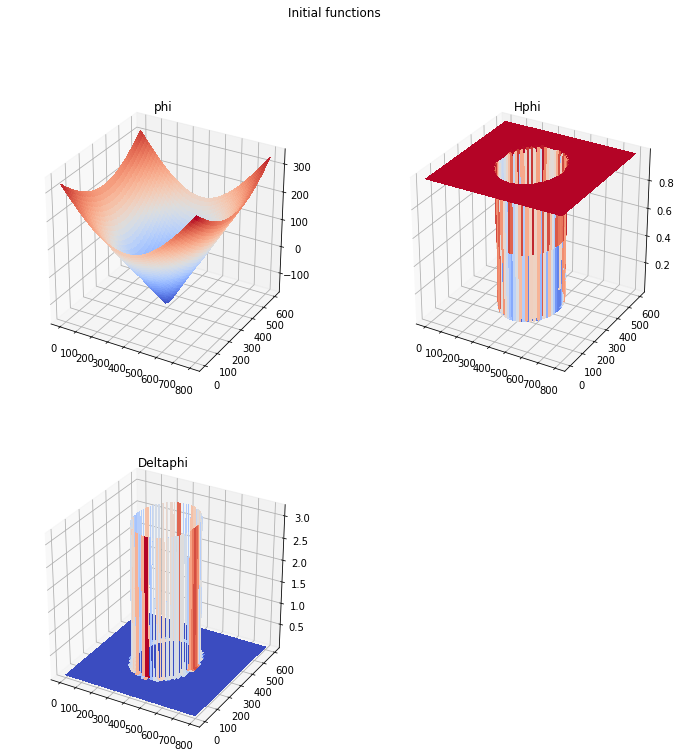

In [53]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

curveInit = scm.imread('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/curve.jpg').astype(np.float32)
#image = mcm.grayfication(image)
curveInit  = 1- scnd.gaussian_filter(curveInit[:,:,1],2)/255
curveInit[(curveInit<0.5).nonzero()]=0
curveInit[curveInit.nonzero()]=1

labIm                      = curveInterior(curveInit)


dist                       = scnd.morphology.distance_transform_edt(1-curveInit).astype(np.float32)
dist[(labIm).nonzero()]  = -dist[(labIm).nonzero()]
#np.loadtxt('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/distance.dat',delimiter=',').astype(np.float32)
#dist = dist/(np.max(dist)-np.min(dist))
phi = dist



# Make data.
xdim = curveInit.shape[0]
ydim = curveInit.shape[1]
Y = np.arange(0, xdim, 1)
X = np.arange(0,ydim, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z0  = phi
eps = 0.1
Z1  = 0.5*(1 + (2/np.pi)*np.arctan(Z0/eps))
Z2  = (1/np.pi)*(eps/(eps**2 + Z0**2))
# Plot the surface.

fig = plt.figure(figsize=(12,12))
fig.suptitle('Initial functions')
ax0 = fig.add_subplot(2, 2, 1,projection='3d')
ax0.set_title('phi')
surf0 = ax0.plot_surface(X, Y, Z0, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)

ax1 = fig.add_subplot(2, 2, 2, projection='3d')


surf1 = ax1.plot_surface(X, Y, Z1, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)
ax1.set_title('Hphi')

ax2   = fig.add_subplot(2,2,3, projection='3d')
ax2.set_title('Deltaphi')
surf2 = ax2.plot_surface(X,Y,Z2,cmap = 'coolwarm',
                       linewidth=0, antialiased=False)



# Customize the z axis.


# Add a color bar which maps values to colors.


plt.show()


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

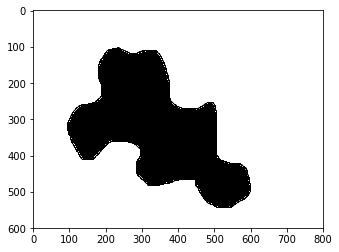

In [54]:
u0 = scm.imread('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/weirdShape.jpg').astype(np.float32)
u0 = mcm.grayfication(255-u0)
plt.imshow(u0,cmap='Greys')
u0


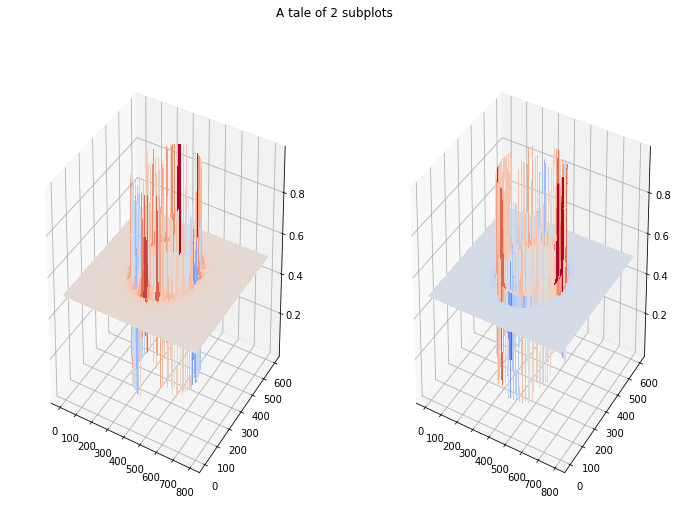

In [60]:
uMinus  = 0.5*(1 + (2/np.pi)*np.arctan(phi/eps))
uPlus = 1-uMinus


xdim = curveInit.shape[0]
ydim = curveInit.shape[1]
Y = np.arange(0, xdim, 1)
X = np.arange(0,ydim, 1)
X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=(12,8))
fig.suptitle('A tale of 2 subplots')
ax0 = fig.add_subplot(1, 2, 1,projection='3d')
surf0 = ax0.plot_surface(X, Y, uPlus, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)

ax1 = fig.add_subplot(1, 2, 2, projection='3d')


surf1 = ax1.plot_surface(X, Y, uMinus, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)


uPlus, uMinus, phi need to be evolved to minimise MS, we solve the following system: 

$u^+ H_{\epsilon} (\phi) = u_0 H_{\epsilon}(\phi)  + \mu \text{div} \left(H_{\epsilon}(\phi) \nabla u^+ \right) $ 

$u^-\left(1- H_{\epsilon} (\phi) \right) = u_0 \left(1- H_{\epsilon}(\phi) \right) + \mu \text{div} \left( \left(1-H_{\epsilon}(\phi) \right) \nabla u^+ \right) $ 

$\frac{\partial \phi}{\partial t}  = \delta_{\epsilon} \left[ \nu \nabla \left( \frac{\nabla \phi}{|\nabla \phi|} - |u^+ - u_0|^2 - \mu |\nabla u^+|^2 + |u^- - u_0|^2 + \mu |\nabla u^-|^2 \right)  \right]$

uPlus, uMinus initailiased as above
Need to evolve the uPlus and Uminus only where phi is positive: figure out how to do this! need to c1 extend uPlus and uMinus

In [79]:
#initialising scalars
delT  = 0.1
h     = 0.1
eps   = 0.1
mu    = 1
nu    = 1
maxit = 20

#initialising arrays
imSize  = phi.shape
Idim    = imSize[0]
Jdim    = imSize[1]
phi = scnd.gaussian_filter(dist,6)


phitemp   = np.zeros(imSize)
uTemp     = np.zeros(imSize)

m         = np.zeros((Idim-2,Jdim-2))
gradPlus  = np.zeros((Idim-2,Jdim-2))
gradMinus = np.zeros((Idim-2,Jdim-2))
C1        = np.zeros((Idim-2,Jdim-2))
C2        = np.zeros((Idim-2,Jdim-2))
C3        = np.zeros((Idim-2,Jdim-2))
C4        = np.zeros((Idim-2,Jdim-2))
c         = np.zeros((Idim-2,Jdim-2))
d         = np.zeros((Idim-2,Jdim-2))



for k in range(0,maxit):
    Hphi = 0.5*(1 + (2/np.pi)*np.arctan(phi/eps))    
    
    c = Hphi[1:Idim-2,1:Jdim-2] + (mu/h**2)*(2*Hphi[1:Idim-2,1:Jdim-2]\
                                                                + Hphi[0:Idim-3,1:Jdim-2]\
                                                                +Hphi[1:Idim-2,0:Jdim-3]) 
    
    d = (1-Hphi[1:Idim-2,1:Jdim-2]) + (mu/h**2)*(2*(1-Hphi[1:Idim-2,1:Jdim-2])\
                                                                    + (1-Hphi[0:Idim-3,1:Jdim-2])\
                                                                    + (1-Hphi[1:Idim-2,0:Jdim-3]) ) 
    
    uTemp[1:Idim-2,1:Jdim-2] = (1/c)*(  (mu/h**2)*(Hphi[2:Idim-1,1:Jdim-2]*uPlus[2:Idim-1,1:Jdim-2]+\
                                                   Hphi[0:Idim-3,1:Jdim-2]*uPlus[0:Idim-3,1:Jdim-2]+\
                                                   Hphi[1:Idim-2,2:Jdim-1]*uPlus[1:Idim-2,2:Jdim-1]+\
                                                   Hphi[1:Idim-2,0:Jdim-3]*uPlus[1:Idim-2,0:Jdim-3] \
                                                  ) + Hphi[1:Idim-2,1:Jdim-2]*u0[1:Idim-2,1:Jdim-2]  )
    uTemp[np.isnan(uTemp)] = uPlus[np.isnan(uTemp)]
    uPlus = uTemp

    uTemp[1:Idim-2,1:Jdim-2] = (1/d)*(  (mu/h**2)*( (1-Hphi[2:Idim-1,1:Jdim-2])*uMinus[2:Idim-1,1:Jdim-2]+\
                                                   (1-Hphi[0:Idim-3,1:Jdim-2])*uMinus[0:Idim-3,1:Jdim-2]+\
                                                   (1-Hphi[1:Idim-2,2:Jdim-1])*uMinus[1:Idim-2,2:Jdim-1]+\
                                                   (1-Hphi[1:Idim-2,0:Jdim-3])*uMinus[1:Idim-2,0:Jdim-3] \
                                                  ) + (1-Hphi[1:Idim-2,1:Jdim-2])*u0[1:Idim-2,1:Jdim-2]  )
    
    uTemp[np.isnan(uTemp)] = uMinus[np.isnan(uTemp)]
    uMinus = uTemp    
    
    C1 = 1/(np.sqrt(  ((phi[2:Idim-1,1:Jdim-2]-phi[1:Idim-2,1:Jdim-2])/h)**2 + \
                                      ((phi[2:Idim-1,2:Jdim-1]-phi[1:Idim-2,0:Jdim-3])/(2*h))**2 \
                                      ))
    C1[(C1<0.0000000001).nonzero()] = 0
    C1[np.isnan(C1)] = 0
    
    
    C2 = 1/(np.sqrt(  ((phi[1:Idim-2,1:Jdim-2]-phi[0:Idim-3,1:Jdim-2])/h)**2 + \
                                      ((phi[0:Idim-3,2:Jdim-1]-phi[0:Idim-3,0:Jdim-3])/(2*h))**2 \
                                      ))  
    C2[(C2<0.0000000001).nonzero()] = 0
    C2[np.isnan(C2)] = 0
    
    C3 = 1/(np.sqrt(  ((phi[2:Idim-1,1:Jdim-2]-phi[0:Idim-3,1:Jdim-2])/(2*h))**2 + \
                                      ((phi[1:Idim-2,2:Jdim-1]-phi[1:Idim-2,1:Jdim-2])/(h))**2 \
                                      )) 
    C3[(C3<0.0000000001).nonzero()] = 0
    C3[np.isnan(C3)] = 0
    
    C4 = 1/(np.sqrt(  ((phi[2:Idim-1,0:Jdim-3]-phi[0:Idim-3,0:Jdim-3])/(2*h))**2 + \
                                      ((phi[1:Idim-2,1:Jdim-2]-phi[1:Idim-2,0:Jdim-3])/(h))**2 \
                                      ))
    C4[(C4<0.0000000001).nonzero()] = 0
    C4[np.isnan(C4)] = 0
    
    gradPlus  = ((uPlus[2:Idim-1,1:Jdim-2] - uPlus[0:Idim-3,1:Jdim-2])/(2*h))**2 +\
                                  ((uPlus[1:Idim-2,2:Jdim-1] - uPlus[1:Idim-2,0:Jdim-3])/(2*h))**2  
    gradMinus = ((uMinus[2:Idim-1,1:Jdim-2] - uMinus[0:Idim-3,1:Jdim-2])/(2*h))**2 +\
                                  ((uMinus[1:Idim-2,2:Jdim-1] - uMinus[1:Idim-2,0:Jdim-3])/(2*h))**2

    m = nu*delT/((h**2*np.pi)*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2)))
    
    phitemp[1:Idim-2,1:Jdim-2] = (1/(1+m*(C1+C2+C3+C4)))*(phi[1:Idim-2,1:Jdim-2] + \
                                                       nu*(delT/(h**2*np.pi))*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2))*\
                                                        ( C1*phi[2:Idim-1,1:Jdim-2] + C2*phi[0:Idim-3,1:Jdim-2] + \
                                                         C3*phi[1:Idim-2,2:Jdim-1] + C4*phi[1:Idim-2,0:Jdim-3] \
                                                       )+\
                                                        delT*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2))*\
                                                        (\
                                                         -(u0[1:Idim-2,1:Jdim-2]-uPlus[1:Idim-2,1:Jdim-2])**2 +\
                                                         (u0[1:Idim-2,1:Jdim-2]-uMinus[1:Idim-2,1:Jdim-2])**2 - \
                                                         mu*gradPlus + mu*gradMinus \
                                                        ))
    phi = phitemp
    #setting boundary values for uPlus,uMinus,phi
    phi[0,:]      = phi[1,:]
    phi[Idim-1,:] = phi[Idim-2,:]
    phi[:,Jdim-1] = phi[:,Jdim-2]
    phi[:,0]      = phi[:,1]
    
    uPlus[0,:]      = uPlus[1,:]
    uPlus[Idim-1,:] = uPlus[Idim-2,:]
    uPlus[:,Jdim-1] = uPlus[:,Jdim-2]
    uPlus[:,0]      = uPlus[:,1]

    uMinus[0,:]      = uMinus[1,:]
    uMinus[Idim-1,:] = uMinus[Idim-2,:]
    uMinus[:,Jdim-1] = uMinus[:,Jdim-2]
    uMinus[:,0]      = uMinus[:,1]
    




-c:65: RuntimeWarning: invalid value encountered in subtract
-c:69: RuntimeWarning: invalid value encountered in add
-c:53: RuntimeWarning: invalid value encountered in less
-c:57: RuntimeWarning: invalid value encountered in less
-c:61: RuntimeWarning: invalid value encountered in less


Diagnosis the loop line by line: Initialising stuff

In [85]:
#initialising scalars
delT  = 0.1
h     = 0.1
eps   = 0.1
mu    = 1
nu    = 1
maxit = 20

#initialising arrays
imSize  = phi.shape
Idim    = imSize[0]
Jdim    = imSize[1]
phi = scnd.gaussian_filter(dist,6)

uMinus  = 0.5*(1 + (2/np.pi)*np.arctan(phi/eps))
uPlus = 1-uMinus

phitemp   = np.zeros(imSize)
uTemp     = np.zeros(imSize)
uTemp1    = np.zeros(imSize)

m         = np.zeros((Idim-2,Jdim-2))
gradPlus  = np.zeros((Idim-2,Jdim-2))
gradMinus = np.zeros((Idim-2,Jdim-2))
gradxx    = np.zeros((Idim-2,Jdim-2))
gradyy    = np.zeros((Idim-2,Jdim-2))
C1        = np.zeros((Idim-2,Jdim-2))
C2        = np.zeros((Idim-2,Jdim-2))
C3        = np.zeros((Idim-2,Jdim-2))
C4        = np.zeros((Idim-2,Jdim-2))
c         = np.zeros((Idim-2,Jdim-2))
d         = np.zeros((Idim-2,Jdim-2))
Niter     = 0

One loop iteration

In [90]:
Hphi = 0.5*(1 + (2/np.pi)*np.arctan(phi/eps))    
    
c = Hphi[1:Idim-2,1:Jdim-2] + (mu/h**2)*(2*Hphi[1:Idim-2,1:Jdim-2]\
                                                                + Hphi[0:Idim-3,1:Jdim-2]\
                                                                +Hphi[1:Idim-2,0:Jdim-3]) 
    
d = (1-Hphi[1:Idim-2,1:Jdim-2]) + (mu/h**2)*(2*(1-Hphi[1:Idim-2,1:Jdim-2])\
                                                                    + (1-Hphi[0:Idim-3,1:Jdim-2])\
                                                                    + (1-Hphi[1:Idim-2,0:Jdim-3]) ) 


#this 1/c, 1/d is blowing shit up, the truncation is not quite working
uTemp[1:Idim-2,1:Jdim-2] = (1/c)*(  (mu/h**2)*(Hphi[2:Idim-1,1:Jdim-2]*uPlus[2:Idim-1,1:Jdim-2]+\
                                                   Hphi[0:Idim-3,1:Jdim-2]*uPlus[0:Idim-3,1:Jdim-2]+\
                                                   Hphi[1:Idim-2,2:Jdim-1]*uPlus[1:Idim-2,2:Jdim-1]+\
                                                   Hphi[1:Idim-2,0:Jdim-3]*uPlus[1:Idim-2,0:Jdim-3] \
                                                  ) + Hphi[1:Idim-2,1:Jdim-2]*u0[1:Idim-2,1:Jdim-2]  )
uTemp[np.isnan(uTemp)] = uPlus[np.isnan(uTemp)]
uPlus = 1*uTemp

uTemp1[1:Idim-2,1:Jdim-2] = (1/d)*(  (mu/h**2)*( (1-Hphi[2:Idim-1,1:Jdim-2])*uMinus[2:Idim-1,1:Jdim-2]+\
                                                   (1-Hphi[0:Idim-3,1:Jdim-2])*uMinus[0:Idim-3,1:Jdim-2]+\
                                                   (1-Hphi[1:Idim-2,2:Jdim-1])*uMinus[1:Idim-2,2:Jdim-1]+\
                                                   (1-Hphi[1:Idim-2,0:Jdim-3])*uMinus[1:Idim-2,0:Jdim-3] \
                                                  ) + (1-Hphi[1:Idim-2,1:Jdim-2])*u0[1:Idim-2,1:Jdim-2]  )
    
uTemp1[np.isnan(uTemp1)] = uMinus[np.isnan(uTemp1)]
uMinus = 1*uTemp1    
"""    
C1 = 1/(np.sqrt(  ((phi[2:Idim-1,1:Jdim-2]-phi[1:Idim-2,1:Jdim-2])/h)**2 + \
                                      ((phi[2:Idim-1,2:Jdim-1]-phi[1:Idim-2,0:Jdim-3])/(2*h))**2 \
                                      ))
C1[(C1<0.0000000001).nonzero()] = 0
C1[np.isnan(C1)] = 0
    
    
C2 = 1/(np.sqrt(  ((phi[1:Idim-2,1:Jdim-2]-phi[0:Idim-3,1:Jdim-2])/h)**2 + \
                                      ((phi[0:Idim-3,2:Jdim-1]-phi[0:Idim-3,0:Jdim-3])/(2*h))**2 \
                                      ))  
C2[(C2<0.0000000001).nonzero()] = 0
C2[np.isnan(C2)] = 0
    
C3 = 1/(np.sqrt(  ((phi[2:Idim-1,1:Jdim-2]-phi[0:Idim-3,1:Jdim-2])/(2*h))**2 + \
                                      ((phi[1:Idim-2,2:Jdim-1]-phi[1:Idim-2,1:Jdim-2])/(h))**2 \
                                      )) 
C3[(C3<0.0000000001).nonzero()] = 0
C3[np.isnan(C3)] = 0
    
C4 = 1/(np.sqrt(  ((phi[2:Idim-1,0:Jdim-3]-phi[0:Idim-3,0:Jdim-3])/(2*h))**2 + \
                                      ((phi[1:Idim-2,1:Jdim-2]-phi[1:Idim-2,0:Jdim-3])/(h))**2 \
                                      ))
C4[(C4<0.0000000001).nonzero()] = 0
C4[np.isnan(C4)] = 0
"""
    
gradPlus  = ((uPlus[2:Idim-1,1:Jdim-2] - uPlus[0:Idim-3,1:Jdim-2])/(2*h))**2 +\
                                  ((uPlus[1:Idim-2,2:Jdim-1] - uPlus[1:Idim-2,0:Jdim-3])/(2*h))**2  
gradMinus = ((uMinus[2:Idim-1,1:Jdim-2] - uMinus[0:Idim-3,1:Jdim-2])/(2*h))**2 +\
                                  ((uMinus[1:Idim-2,2:Jdim-1] - uMinus[1:Idim-2,0:Jdim-3])/(2*h))**2

"""
m = nu*delT/((h**2*np.pi)*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2)))


phitemp[1:Idim-2,1:Jdim-2] =  (1/(1+m*(C1+C2+C3+C4)))*(phi[1:Idim-2,1:Jdim-2] + \
                                                       nu*(delT/(h**2*np.pi))*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2))*\
                                                        ( C1*phi[2:Idim-1,1:Jdim-2] + C2*phi[0:Idim-3,1:Jdim-2] + \
                                                         C3*phi[1:Idim-2,2:Jdim-1] + C4*phi[1:Idim-2,0:Jdim-3] \
                                                       )+\
                                                        delT*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2))*\
                                                        (\
                                                         -(u0[1:Idim-2,1:Jdim-2]-uPlus[1:Idim-2,1:Jdim-2])**2 +\
                                                         (u0[1:Idim-2,1:Jdim-2]-uMinus[1:Idim-2,1:Jdim-2])**2 - \
                                                         mu*gradPlus + mu*gradMinus \
                                                        ))
"""

grady, gradx = np.gradient(phi)

normgrad     = (gradx[1:Idim-2,1:Jdim-2]**2+grady[1:Idim-2,1:Jdim-2]**2)**(1.5)

normgrad[(normgrad<0.0000000001).nonzero()] = 1
#force gradxx,gradxy,gradyy to be zero on boundary by only calculating it on inside
gradxx = phi[1:xdim-2,2:ydim-1] - 2*phi[1:xdim-2,1:ydim-2] + phi[1:xdim-2,0:ydim-3]

gradyy = phi[2:xdim-1,1:ydim-2] - 2*phi[1:xdim-2,1:ydim-2] + phi[0:xdim-3,1:ydim-2]

gradxy = (phi[2:xdim-1,2:ydim-1] -phi[2:xdim-1,0:ydim-3] -phi[0:xdim-3,2:ydim-1] + phi[0:xdim-3,0:ydim-3]  )/4   

div    = (gradxx*grady[1:Idim-2,1:Jdim-2]*grady[1:Idim-2,1:Jdim-2] \
          - 2*gradx[1:Idim-2,1:Jdim-2]*grady[1:Idim-2,1:Jdim-2]*gradxy\
          + gradyy*gradx[1:Idim-2,1:Jdim-2]*gradx[1:Idim-2,1:Jdim-2])/(normgrad)
div[(normgrad<0.0000000001).nonzero()] = 0

"""
phitemp[1:Idim-2,1:Jdim-2] =  phi[1:Idim-2,1:Jdim-2] + \
                               nu*(delT/(h**2*np.pi))*(eps/(eps**2+phi[1:Idim-2,1:Jdim-2]**2))*(div \
                                                         -(u0[1:Idim-2,1:Jdim-2]-uPlus[1:Idim-2,1:Jdim-2])**2 +\
                                                         (u0[1:Idim-2,1:Jdim-2]-uMinus[1:Idim-2,1:Jdim-2])**2 - \
                                                         mu*gradPlus + mu*gradMinus \
                                                        )
"""
phitemp[1:Idim-2,1:Jdim-2] =  phi[1:Idim-2,1:Jdim-2] + \
                               (nu*div \
                               -(u0[1:Idim-2,1:Jdim-2]-uPlus[1:Idim-2,1:Jdim-2])**2 +\
                                (u0[1:Idim-2,1:Jdim-2]-uMinus[1:Idim-2,1:Jdim-2])**2 - \
                                 mu*gradPlus + mu*gradMinus \
                                  )
phi = 1*phitemp
    #setting boundary values for uPlus,uMinus,phi
phi[0,:]      = phi[1,:]
phi[Idim-1,:] = phi[Idim-2,:]
phi[:,Jdim-1] = phi[:,Jdim-2]
phi[:,0]      = phi[:,1]
    
uPlus[0,:]      = uPlus[1,:]
uPlus[Idim-1,:] = uPlus[Idim-2,:]
uPlus[:,Jdim-1] = uPlus[:,Jdim-2]
uPlus[:,0]      = uPlus[:,1]

uMinus[0,:]      = uMinus[1,:]
uMinus[Idim-1,:] = uMinus[Idim-2,:]
uMinus[:,Jdim-1] = uMinus[:,Jdim-2]
uMinus[:,0]      = uMinus[:,1]
    

Niter = Niter+1

Plotting the result of one iteration

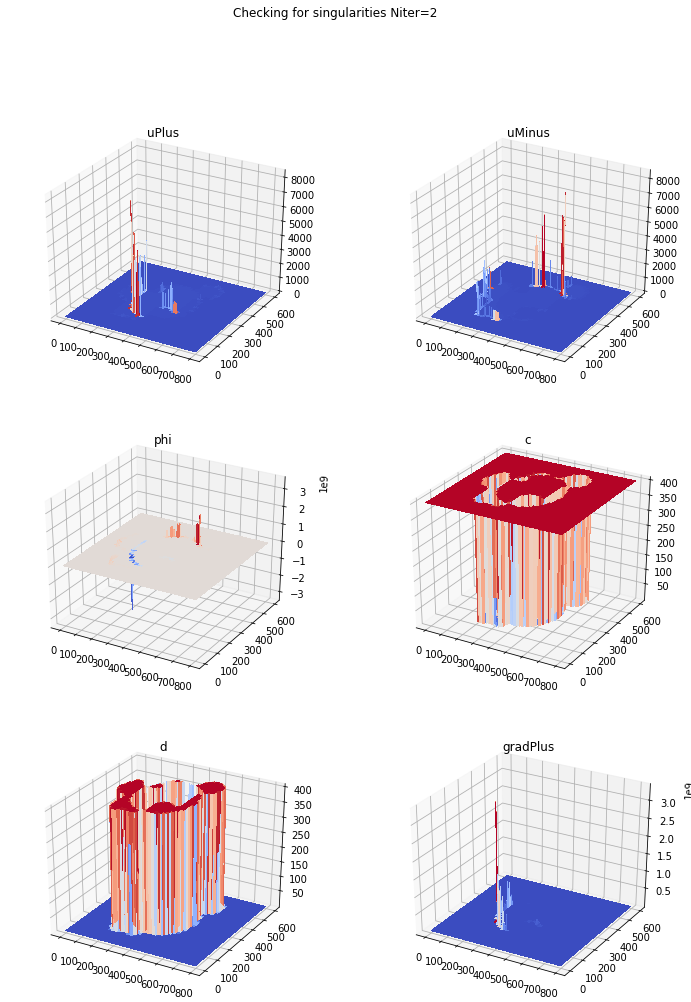

In [91]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Make data.


# Plot the surface.

fig = plt.figure(figsize=(12,16))
fig.suptitle('Checking for singularities Niter='+ str(Niter))
ax0 = fig.add_subplot(3, 2, 1,projection='3d')
ax0.set_title('uPlus')
Y = np.arange(0,uPlus.shape[0], 1)
X = np.arange(0,uPlus.shape[1], 1)
X, Y = np.meshgrid(X, Y)
surf0 = ax0.plot_surface(X, Y, uPlus, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)



ax1 = fig.add_subplot(3, 2, 2, projection='3d')
ax1.set_title('uMinus')
Y = np.arange(0,uMinus.shape[0], 1)
X = np.arange(0,uMinus.shape[1], 1)
X, Y = np.meshgrid(X, Y)
surf1 = ax1.plot_surface(X, Y, uMinus, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)

ax2   = fig.add_subplot(3,2,3, projection='3d')
ax2.set_title('phi')
Z = phi
Y = np.arange(0,Z.shape[0], 1)
X = np.arange(0,Z.shape[1], 1)
X, Y = np.meshgrid(X, Y)
surf2 = ax2.plot_surface(X,Y,Z,cmap = 'coolwarm',
                       linewidth=0, antialiased=False)


ax3   = fig.add_subplot(3,2,4,projection='3d')
#ax3    = fig.add_subplot(3,2,4)
ax3.set_title('c')
#ax3.imshow(d)
Z = c
Y = np.arange(0,Z.shape[0], 1)
X = np.arange(0,Z.shape[1], 1)
X, Y = np.meshgrid(X, Y)
surf3 = ax3.plot_surface(X,Y,Z,cmap = 'coolwarm',linewidth=0, antialiased=False)



ax4   = fig.add_subplot(3,2,5,projection='3d')
ax4.set_title('d')
Z = d
Y = np.arange(0,Z.shape[0], 1)
X = np.arange(0,Z.shape[1], 1)
X, Y = np.meshgrid(X, Y)
surf4 = ax4.plot_surface(X,Y,Z,cmap = 'coolwarm',
                       linewidth=0, antialiased=False)

ax5   = fig.add_subplot(3,2,6,projection='3d')
ax5.set_title('gradPlus')
Z = gradPlus
Y = np.arange(0,Z.shape[0], 1)
X = np.arange(0,Z.shape[1], 1)
X, Y = np.meshgrid(X, Y)
surf5 = ax5.plot_surface(X,Y,Z,cmap = 'coolwarm',
                       linewidth=0, antialiased=False)
#ax5.set_zlim(-100,100)


# Customize the z axis.


# Add a color bar which maps values to colors.


plt.show()


In [28]:
uPlus[1:Idim-2,1:Jdim-2].shape
X.shape

(598, 798)

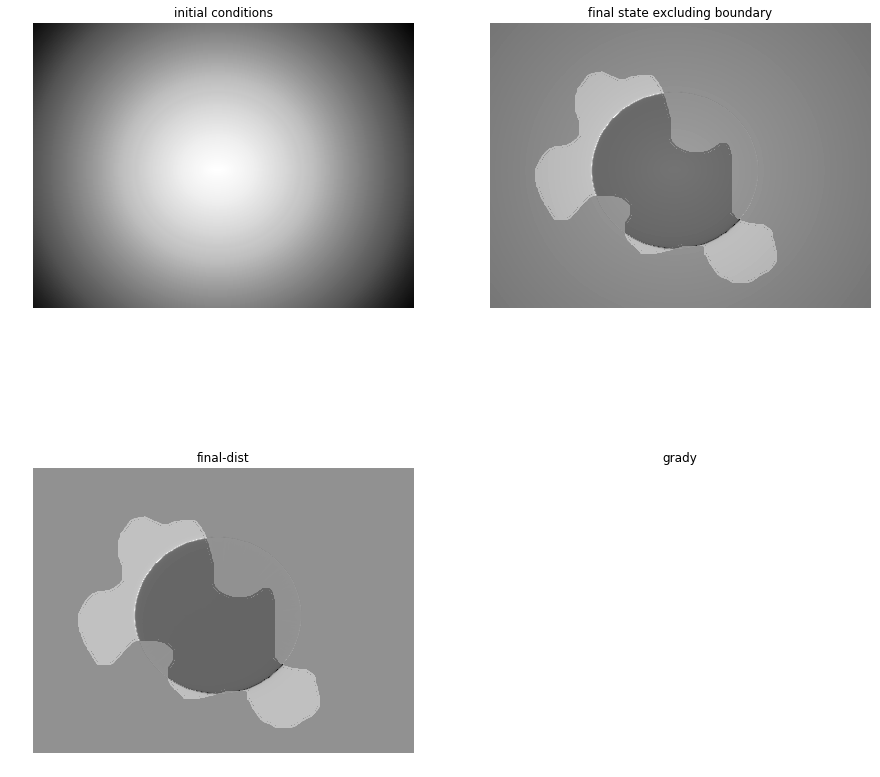

In [88]:
%matplotlib inline
colmap = 'Greys'
fig2 = plt.figure(1,figsize=(15,15))

ax0 = fig2.add_subplot(221)
ax0.imshow(dist,cmap=colmap)
ax0.set_title('initial conditions')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(phi[1:xdim-2,1:ydim-2],cmap=colmap)
ax1.set_title('final state excluding boundary')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(phi[1:xdim-2,1:ydim-2]-dist[1:xdim-2,1:ydim-2],cmap=colmap)
ax2.set_title('final-dist')
ax2.axis('off')

ax3 = fig2.add_subplot(224)
ax3.imshow(C1,cmap=colmap)
ax3.set_title('grady')
ax3.axis('off')
plt.show()

(-0.5, 799.5, 599.5, -0.5)

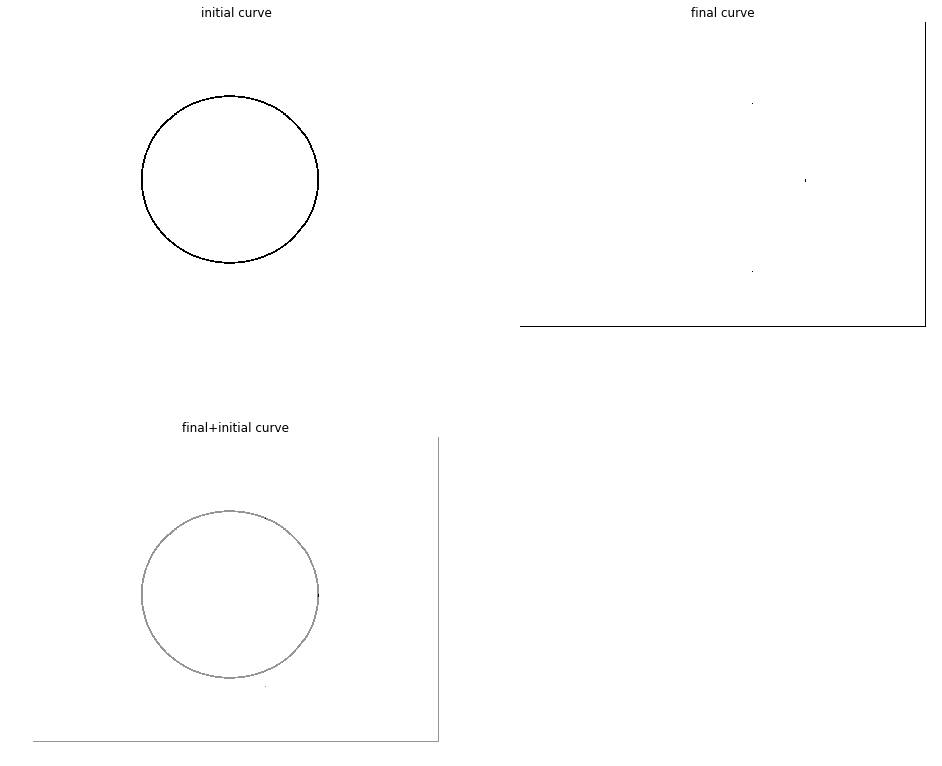

In [89]:
#==============================================================
def findZeros(dist,tol):
    forme = dist.shape
    dimI  = forme[0]
    dimJ  = forme[1]
    
    
    dist       = np.reshape(dist,dimI*dimJ,order = 'F')
    curveArray = np.zeros(dimI*dimJ)
    
    for k in range(0,dimI*dimJ):
        if(dist[k]**2<tol):
            curveArray[k] = 1
            
    curveArray = np.reshape(curveArray,forme,order='F')
    return curveArray
#===============================================================

curveInit  = findZeros(dist,0.7)
curveFinal =  findZeros(phi,0.5)
    
%matplotlib inline
colmap = 'Greys'
fig2 = plt.figure(figsize=(16,14))

ax0 = fig2.add_subplot(221)
ax0.imshow(curveInit,cmap=colmap)
ax0.set_title('initial curve')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(curveFinal,cmap=colmap)
ax1.set_title('final curve')
ax1.axis('off')    
    
ax2 = fig2.add_subplot(223)
ax2.imshow(curveFinal+curveInit,cmap=colmap)
ax2.set_title('final+initial curve')
ax2.axis('off') 

Some code for solving $\Delta u = f$ on $\Omega$, $u=g$ on $\partial \Omega$ for a weird shaped omega
We have $u = u_0 + \mu \Delta u$ given on $\Omega_1 \subset \Omega_0$ and $\frac{\partial u }{\partial \pmb{n}}=0$ on 
$\partial \Omega_1$ and we want to extend $u$ to $\Omega_0 \setminus \Omega_1$ via $\Delta u = 0$ on $\Omega_0 \setminus \Omega_1$ with values given for $\pmb{x} \in \Omega_1$